In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from plot_keras_history import show_history, plot_history
import hyperopt 
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, GRU, Bidirectional
from hyperopt import hp, tpe, Trials, fmin, rand
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK
import time
import threading
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import sklearn
from numba import jit
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error
import math
import tensorflow_probability as tfp
import scipy
from tensorflow.keras.callbacks import EarlyStopping
import plotly.figure_factory as ff
tfd = tfp.distributions

In [2]:
excel=pd.read_excel(r"C:\Users\Francesco\OneDrive\Desktop\esami\deep learning\esame\data_bresso.xlsx")

df=pd.DataFrame(data=excel)

df['dateTime']=df['dateTime']-df['dateTime'][0]


In [3]:
df['cloudbase']=df['cloudbase']/df['cloudbase'].max()
df['outHumidity']=df['outHumidity']/df['outHumidity'].max()
df['outTemp']=df['outTemp']/df['outTemp'].max()
df['barometer']=df['barometer']/df['barometer'].max()
df['rain']=df['rain']/df['rain'].max()
df['windDir']=df['windDir']/df['windDir'].max()
df['windSpeed']=df['windSpeed']/df['windSpeed'].max()


In [4]:
df = df.iloc[7:]

In [5]:
df.drop(columns=['dateTime', 'Date', 'Time', 'windDir'], axis=1, inplace=True)
df.dropna(how='any', inplace=True)

ytrain=df['outHumidity'][0:int(len(df)*0.7)]
yval=df['outHumidity'][int(len(df)*0.7):int(len(df)*0.85)]
ytest=df['outHumidity'][int(len(df)*0.85):]

df.drop(columns=['outHumidity'], axis=1, inplace=True)

xtest=df[int(len(df)*0.85):]
xval=df[int(len(df)*0.7): int(len(df)*0.85)]
xtrain=df[0:int(len(df)*0.7)]

lr=0.001
batch=32
epochs=30
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [6]:
lr=0.001
sns.set(style="darkgrid")
opt = tf.keras.optimizers.Adam(learning_rate=lr)

Epoch 1/30
858/858 [==============================] - 28s 16ms/step - loss: 0.0290 - val_loss: 0.0029
Epoch 2/30
858/858 [==============================] - 11s 12ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 3/30
858/858 [==============================] - 10s 12ms/step - loss: 0.0025 - val_loss: 4.0719e-04
Epoch 4/30
858/858 [==============================] - 11s 12ms/step - loss: 0.0019 - val_loss: 2.6064e-04
Epoch 5/30
858/858 [==============================] - 11s 12ms/step - loss: 0.0015 - val_loss: 1.5547e-04
Epoch 6/30
858/858 [==============================] - 10s 12ms/step - loss: 0.0012 - val_loss: 2.8323e-04
Epoch 7/30
858/858 [==============================] - 11s 12ms/step - loss: 9.1241e-04 - val_loss: 4.2883e-04
Epoch 8/30
858/858 [==============================] - 10s 12ms/step - loss: 7.1096e-04 - val_loss: 7.1568e-05
Epoch 9/30
858/858 [==============================] - 10s 12ms/step - loss: 5.5510e-04 - val_loss: 1.0379e-04
Epoch 10/30
858/858 [=====================

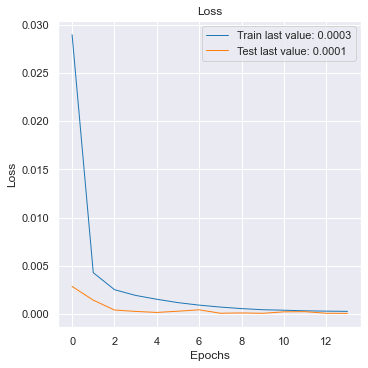

168.47842383384705 s


In [7]:
start=time.time()
def LSTM_model_tot(function):
    m=tf.keras.models.Sequential()
    m.add(Bidirectional(LSTM(units = 64, activation='tanh', return_sequences = True), input_shape = (5, 1)))
    m.add(Dropout(0.2))
    m.add(Bidirectional(LSTM(units = 64, activation='tanh', return_sequences = True)))
    m.add(Dropout(0.2))
    m.add(Dense(units=1))
    return m

model=LSTM_model_tot('tanh')
model.compile(optimizer = opt, loss = 'mean_squared_error')
hist=model.fit(xtrain, 
               ytrain, 
               validation_data=(xval, yval), 
               epochs = 30, 
               batch_size = 32,
               callbacks=[EarlyStopping(monitor='loss', min_delta=0.0003, patience=3, verbose=1, mode='min')])
end=time.time()

ypredict=model.predict(xtest)


plot_history(hist)
plt.show()
print(end-start, 's')

In [8]:
ypredict=ypredict[:, 1].reshape(5883)
err=np.sqrt(sklearn.metrics.mean_squared_error(ypredict, ytest))
err

0.005778696195620429

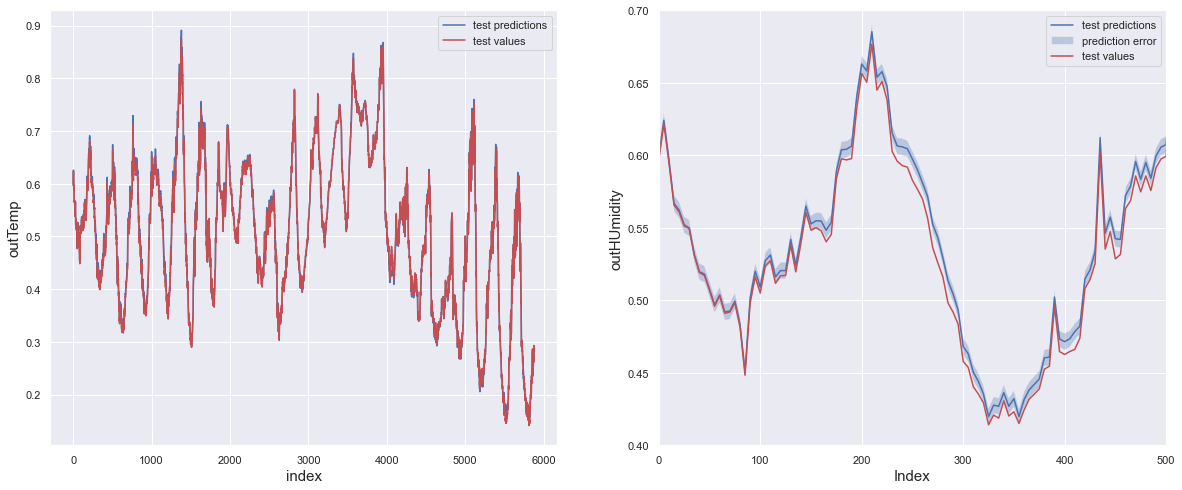

In [9]:
x=np.arange(0, 5883)
sns.set(style="darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(x, ypredict, color='b')
ax[0].plot(x, ytest, color='r')
ax[0].set_xlabel("index",fontsize=15)
ax[0].set_ylabel("outTemp",fontsize=15)
ax[0].grid(True)
ax[0].legend(['test predictions', 'test values'])

ax[1].plot(x[::5], ypredict[::5], c='b')
ax[1].fill_between(x[::5], ypredict[::5]-err, ypredict[::5]+err, alpha=0.3)
ax[1].plot(x[::5], ytest[::5], color='r')
ax[1].set_xlabel("Index",fontsize=15)
ax[1].set_ylabel("outHUmidity",fontsize=15)
ax[1].set_ylim(0.4, 0.7)
ax[1].set_xlim(0, 500)
ax[1].grid(True)
ax[1].legend(['test predictions', 'prediction error', 'test values'])

plt.show()